Implement a transformer architecture and improve and analyze it's arous aspects rather than focus on a particular paper

Use percentage changes as data source instead of prices

If we make a predictor which just guesses next day's price as the same as today’s price, it would have better than 95% accuracy. 

Guessing whether next day price will go up or down i.e. as a classification problem.

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/CS7643 Final Project/'  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS7643 Final Project


In [2]:
from data.get_dataset import GetDataset, StockData

FAKE_DATA=False
REPEAT_ONE_SMALL_BATCH=False
USE_TRANSFORMER=True
NUM_DAYS=2

csv = './data/SPXDailyData.csv'
df = GetDataset(csv)
dataset = df.get_data()
if REPEAT_ONE_SMALL_BATCH:
  dataset = dataset[0:10]
  if FAKE_DATA:
    dataset[:][0:5]=.6
    dataset[:][5:]=.4
    dataset['Next_Day_Change'][0:5]=0
    dataset['Next_Day_Change'][5:]=1

#split into 3
valid_frac, test_frac = 0.2, 0.2
train_sz=int(dataset.shape[0]*(1-(valid_frac+test_frac)))
valid_sz=int(dataset.shape[0]*(valid_frac))
df_train = dataset[               0:train_sz]
df_valid = dataset[        train_sz:train_sz+valid_sz]
df_test = dataset[train_sz+valid_sz:]

#convert to sequence data and make dataset
train_dataset = StockData(df_train.to_numpy(), num_days=NUM_DAYS)
valid_dataset = StockData(df_valid.to_numpy(), num_days=NUM_DAYS) 
test_dataset = StockData(df_test.to_numpy(), num_days=NUM_DAYS) 


/content/drive/MyDrive/CS7643 Final Project/data/get_dataset.py:40: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  self.df.drop('Symbol', 1, inplace=True)


In [3]:
print(train_dataset[:][0].shape)
print(train_dataset.num_samples)
print(dataset)
print(train_dataset[:])

torch.Size([14090, 2, 4])
14090
           Open      High       Low     Close  Next_Day_Change
1      0.526143  0.408969  0.521890  0.526143                1
2      0.568924  0.462328  0.565055  0.568924                0
3      0.527583  0.410765  0.523342  0.527583                0
4      0.531983  0.416253  0.527782  0.531983                0
5      0.548913  0.437370  0.544864  0.548913                1
...         ...       ...       ...       ...              ...
23482  0.615969  0.510438  0.589644  0.612391                1
23483  0.587851  0.482741  0.601541  0.585322                1
23484  0.590646  0.481443  0.582469  0.583473                0
23485  0.585713  0.453561  0.568904  0.550846                1
23486  0.556068  0.471455  0.575554  0.582507                0

[23486 rows x 5 columns]
(tensor([[[0.5261, 0.4090, 0.5219, 0.5261],
         [0.5689, 0.4623, 0.5651, 0.5689]],

        [[0.5689, 0.4623, 0.5651, 0.5689],
         [0.5276, 0.4108, 0.5233, 0.5276]],

        [

In [4]:
from models.my_transformer import TransformerModelImpl
from torch.utils.data import DataLoader
class hyperparameters:
    n_layers = 1
    num_heads = 1
    model_dim = 4
    forward_dim = 16
    output_dim = 1
    dropout = 3e-4
    n_epochs = 100
    lr = 0.1 if USE_TRANSFORMER else 0.01
    batch_size = 1024

modelT = TransformerModelImpl(hyperparameters)
train_loader = DataLoader(train_dataset, batch_size=train_dataset.num_samples if REPEAT_ONE_SMALL_BATCH else hyperparameters.batch_size, shuffle=False)#todo while debuggin set to false
valid_loader = DataLoader(valid_dataset, batch_size=valid_dataset.num_samples if REPEAT_ONE_SMALL_BATCH else hyperparameters.batch_size, shuffle=False)#todo while debuggin set to false

In [5]:
from torch import nn
from torch.nn import functional as F
class FCNet(nn.Module):
  def __init__(self,in_shape):
    super(FCNet,self).__init__()
    self.fc_layer1 = nn.Linear(in_shape,in_shape*4)
    self.fc_layer2 = nn.Linear(in_shape*4,in_shape*8)
    self.fc_layer3 = nn.Linear(in_shape*8,1)
  def forward(self,x):
    #print(x.shape)
    x = torch.relu(self.fc_layer1(x))
    x = torch.relu(self.fc_layer2(x))
    x = self.fc_layer3(x)
    return x.reshape(x.shape[0],-1)
modelFC = FCNet((train_dataset[:][0].shape[2])*NUM_DAYS)

## Training

Epoch 2: Training Loss: 0.6946. Training Acc: 0.3376. Validation Loss: 0.6987. Validation Acc: 0.3059.
Epoch 52: Training Loss: 0.6937. Training Acc: 0.3324. Validation Loss: 0.6970. Validation Acc: 0.3059.


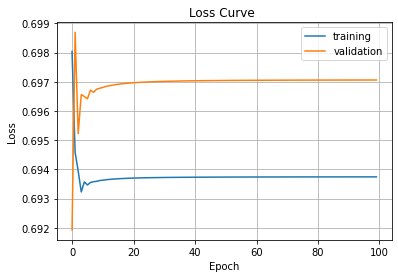

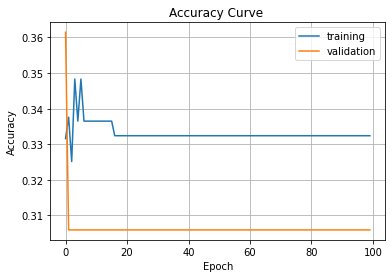

In [6]:
from utils import plot_curves
from utils import train
from utils import evaluate
import torch
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

model = modelT if USE_TRANSFORMER else modelFC
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=1)#constant
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

avg_train_loss,avg_train_acc,avg_valid_loss,avg_valid_acc=[],[],[],[]
model.float()
for epoch in range(hyperparameters.n_epochs):
    train_loss, atl, ata = train(model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)
    _, avl, ava = evaluate(model, valid_loader, criterion)
    if epoch%50==1:
      print("Epoch %d: Training Loss: %.4f. Training Acc: %.4f. Validation Loss: %.4f. Validation Acc: %.4f." % (epoch+1, atl, ata, avl, ava))
    avg_train_loss.append(atl.item())
    avg_train_acc.append(ata)
    avg_valid_loss.append(avl.item())
    avg_valid_acc.append(ava)
plot_curves(avg_train_loss,avg_train_acc,avg_valid_loss,avg_valid_acc, info='', save=False)   
 

In [7]:

a,b=train_dataset[:]
print(a.shape)
print(b.shape)
print(b)

torch.Size([14090, 2, 4])
torch.Size([14090, 1])
tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [0]])


## Validating Predictions

In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
model.eval()
features, targets = test_dataset[:]
predictions = model(features.float())
pred=torch.round(torch.sigmoid(predictions)).long()
print(classification_report(targets.detach().numpy(), pred.detach().numpy(), output_dict=True)['weighted avg']['f1-score'])

0.3894901440953791


## TODO

In [9]:
# 1. Review/Fix Transformer Implementation
# 2. Review/Fix Training and Testing
# 3. Review/Fix Predictions with Tensors
# 4. Implement Accuracy
# 5. Implement Charting
# 6. Experimentation